In [8]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble 
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
import math
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-28 12:04:35,012: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
def decimalToBinary(n):
    return "{0:b}".format(int(n))
    

In [10]:
input_list = [1, 5, 4, 10, 12, 11, 2, 7]
m = int(math.ceil(math.log(max(input_list), 2))) # The length of the bitstring 
n_input = int(math.log(len(input_list), 2)) # This shall be the number of qubits representing the indices
binary_list = [] # This list holding the binary conversion bitstrings with length m each
for x in input_list:
    binary_list.append(decimalToBinary(x))
print(binary_list)
n = n_input
qc = QuantumCircuit(n)
winning_indices = []
print(m)
print(n)
## Design of the looked for numbers based on the bits string size m
if m == 6:
    winning_indices.append(input_list.index(21))
    winning_indices.append(input_list.index(42))
if m == 5:
    winning_indices.append(input_list.index(10))
    winning_indices.append(input_list.index(21))
if m == 4:
    winning_indices.append(input_list.index(5))
    winning_indices.append(input_list.index(10))
if m == 3:
    winning_indices.append(input_list.index(2))
    winning_indices.append(input_list.index(5))
if m == 2:
    winning_indices.append(input_list.index(1))
    winning_indices.append(input_list.index(2))
if m < 2:
    print("Please enter a value >= 1")

print(winning_indices)
## DEsign of the Z Operator based on the length of the input list (2 ^ n)
if n == 2:
    z_operator_matrix = np.asmatrix(np.eye(4), dtype=int)
    z_operator_matrix[1, 1] = -1
    z_operator_matrix[2, 2] = -1
if n == 3:
    z_operator_matrix = np.asmatrix(np.eye(8), dtype=int)
    z_operator_matrix[2, 2] = -1
    z_operator_matrix[5, 5] = -1
if n == 4:
    z_operator_matrix = np.asmatrix(np.eye(16), dtype=int)
    z_operator_matrix[5, 5] = -1
    z_operator_matrix[10, 10] = -1
if n == 5:
    z_operator_matrix = np.asmatrix(np.eye(32), dtype=int)
    z_operator_matrix[21, 21] = -1
    z_operator_matrix[10, 10] = -1

oracle_z = UnitaryGate(z_operator_matrix, "U$_\omega$")

qc.unitary(oracle_z,list(range(n)))
oracle_ex3 = qc.to_gate()


['1', '101', '100', '1010', '1100', '1011', '10', '111']
4
3
[1, 3]


In [11]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [12]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [13]:
#n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, list(range(n)))
grover_circuit.append(oracle_ex3, list(range(n)))
grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌──────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0             ├┤0       ├─░─┤M├──────
        ├───┤│              ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 circuit-256 ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│              ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2             ├┤2       ├─░──╫──╫─┤M├
        └───┘└──────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════════════════════╩══╩══╩═
                                           0  1  2

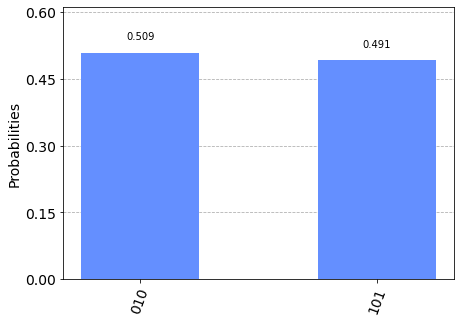

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)